In [4]:
# Imports

# Packages for working with the OS, defining and getting path names, listing files in directories etc. as well as working with json formatted data
import os
from urllib.parse import urlparse
import json
from io import BytesIO

# Packages for working with datetime and timing
from datetime import datetime
import time

# Numerical/tabular packages
import numpy as np
import pandas as pd
import math
from math import floor, ceil

# Packages for downloading lidar data
import earthaccess

# Packages for making api general API calls
import requests

# Visualising and plotting images
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import folium

import rasterio
from rasterio.plot import show
from rasterio.warp import transform_bounds, reproject, Resampling
from rasterio.transform import from_bounds

from IPython.display import display
from IPython.display import Image as IPyImage

from PIL import Image, ImageDraw

# Processing lidar point-cloud data to DTM, DSM and CHMs
import pdal

# Other
import laspy
from scipy.interpolate import griddata
from geopy.distance import distance

tile_index = None

/Users/jamesbyers/code/github/Kaggle/openai_to_z/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# OPTIONAL - Only required if downloading lidar tile metadata (.csv) and tile data (.laz) from the datase
def authenticate_earthaccess():
    try:
        auth = earthaccess.login()
        if auth.authenticated:
            print("Successfully authenticated with earthaccess.")
        else:
            print("Authentication failed. Check credentials.")
    except Exception as e:
        print(f"An error occurred during earthaccess login: {e}")
    
    return auth.authenticated

print(authenticate_earthaccess())

Successfully authenticated with earthaccess.
True


In [6]:
# OPTIONAL - Download earthaccess dataset metadata file
doi = "10.3334/ORNLDAAC/1644"

datasets = earthaccess.search_datasets(doi=doi)

def get_metadata(dataset, verbose=True):

    # general metadata
    native_id = dataset["meta"]["native-id"]
    concept_id = dataset["meta"]["concept-id"]
    granule_count = dataset["meta"]["granule-count"]
    abstract = dataset["umm"]["Abstract"]

    # spatial extent metadata
    spatial_extent = dataset["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["BoundingRectangles"]
    west = spatial_extent[0]["WestBoundingCoordinate"]
    north = spatial_extent[0]["NorthBoundingCoordinate"]
    east = spatial_extent[0]["EastBoundingCoordinate"]
    south = spatial_extent[0]["SouthBoundingCoordinate"]

    # temporal extent metadata
    temporal_extent = dataset["umm"]["TemporalExtents"][0]["RangeDateTimes"][0]
    begin = datetime.strptime(temporal_extent["BeginningDateTime"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y-%m-%d")
    end = datetime.strptime(temporal_extent["EndingDateTime"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y-%m-%d")
    
    metadata = {
        "native_id": native_id,
        "concept_id": concept_id,
        "granule_count": granule_count,
        "spatial_extent": {
            "west": west,
            "north": north,
            "east": east,
            "south": south
        },
        "temporal_extent": {
            "begin": begin,
            "end": end
        },
        "abstract": abstract
    }

    if verbose:
        print(f"Native ID: {native_id}")
        print(f"Granule count: {granule_count}")
        print(f"Spatial extent (west, north, east, south): {west:.4f}, {north:.4f}, {east:.4f}, {south:.4f}")
        print(f"Temporal extent: {begin} to {end}")
        print("Abstract:")
        print(abstract)

    return metadata

metadata = get_metadata(datasets[0], verbose=False)
concept_id = metadata["concept_id"]
print(f"Concept ID: {concept_id}")

# OPTIONAL - download tile_metadata_tile .csv

# Coordinates of site Z-Mt-04
lATITUDE    = -9.8654
LONGITUDE   = -57.6760
DELTA       = 0.1

bbox = (
    LONGITUDE - DELTA,
    lATITUDE - DELTA,
    LONGITUDE + DELTA,
    lATITUDE + DELTA
)

results = earthaccess.search_data(
    concept_id = concept_id,
    bounding_box = bbox,
    cloud_hosted=False
)

path_to_tiles = os.path.join(
    os.getcwd(),
    "data"
)

tile_metadata_file_path = earthaccess.download(results[0], path_to_tiles)[0]

tile_metadata_df = pd.read_csv(tile_metadata_file_path)
tile_metadata_df.head(1)

Concept ID: C2398128915-ORNL_CLOUD


QUEUEING TASKS | : 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 1133.60it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]


,filename,max_lat,min_lat,max_lon,min_lon,file_type,file_size_mb,file_format,version,created,utmzone,srs
0,ANA_A01_2017_laz_0.laz,-3.363488,-3.372548,-54.992912,-55.001927,pointcloud,85.374953,LAS/LAZ,1.2,214/2017,21S,+proj=utm +zone=21 +south +ellps=GRS80 +towgs8...


In [13]:
results[0]

Collection: {'ShortName': 'LiDAR_Forest_Inventory_Brazil_1644', 'Version': '1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -68.2898, 'EastBoundingCoordinate': -39.058, 'NorthBoundingCoordinate': -1.57947, 'SouthBoundingCoordinate': -26.6912}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2008-01-01T00:00:00.000Z', 'EndingDateTime': '2018-12-31T23:59:59.000Z'}}
Size(MB): 0.64406
Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/cms/LiDAR_Forest_Inventory_Brazil/data/cms_brazil_lidar_tile_inventory.csv']

In [4]:
# OPTIONAL - Get tile dimensions (functions)
def get_tile_midpoint(tile_index):

    mid_lat = (tile_metadata_df.iloc[tile_index]["max_lat"] + tile_metadata_df.iloc[tile_index]["min_lat"])/2

    mid_lon = (tile_metadata_df.iloc[tile_index]["max_lon"] + tile_metadata_df.iloc[tile_index]["min_lon"])/2

    return mid_lat, mid_lon

def get_tile_corners(tile_index):
    min_lat = tile_metadata_df.iloc[tile_index]["min_lat"]
    max_lat = tile_metadata_df.iloc[tile_index]["max_lat"]

    min_lon = tile_metadata_df.iloc[tile_index]["min_lon"]
    max_lon = tile_metadata_df.iloc[tile_index]["max_lon"]

    return (float(min_lat), float(max_lat), float(min_lon), float(max_lon))

def get_tile_dimensions(tile_index):

    min_lat = tile_metadata_df.iloc[tile_index]["min_lat"]
    max_lat = tile_metadata_df.iloc[tile_index]["max_lat"]

    min_lon = tile_metadata_df.iloc[tile_index]["min_lon"]
    max_lon = tile_metadata_df.iloc[tile_index]["max_lon"]

    mid_lat, _ = get_tile_midpoint(tile_index)

    metres_per_deg_lat = 111320
    metres_per_deg_lon = 111320 * math.cos(math.radians(mid_lat))

    width_m = abs(min_lon - max_lon) * metres_per_deg_lon
    height_m = abs(min_lat - max_lat)  * metres_per_deg_lat

    return width_m, height_m

# OPTIONAL - See Esri.WorldImagery low-res satellite image of tile
# Centre point

def see_satellite_imagery(min_lat, max_lat, min_lon, max_lon):
    # Compute approx bounds 500 m in each direction
    d = 0.5  # km
    south = min_lat
    north = max_lat
    west = min_lon
    east = max_lon

    # Create map centred at lat/lon
    # m = folium.Map(location=[lat, lon], zoom_start=17, tiles="Esri.WorldImagery")
    centre_lat = (min_lat + max_lat) / 2
    centre_lon = (min_lon + max_lon) / 2
    m = folium.Map(location=[centre_lat, centre_lon], zoom_start=17, tiles="Esri.WorldImagery")

    # Fit to 1 km bounding box
    m.fit_bounds([[south, west], [north, east]])

    # Optional: add rectangle to highlight 1 km tile
    folium.Rectangle(
        bounds=[[south, west], [north, east]],
        color="red", fill=False
    ).add_to(m)

    # Display
    display(m)

def print_tile_metadata(tile_index):

    tile_dimensions = get_tile_dimensions(tile_index)

    tile_area = (tile_dimensions[0] * tile_dimensions[1]) * 10**-6
    tile_name = tile_metadata_df.iloc[tile_index]["filename"]
    print(f"Tile index: {tile_index}")
    print(f"Tile name: {tile_name}")
    print(f"Tile dimensions (width x height): {tile_dimensions[0]:.0f} x  {tile_dimensions[1]:.0f} m")
    print(f"Tile area: {tile_area:.2f} km**2")

    mid_lat, mid_lon = get_tile_midpoint(tile_index)

    print(f"Tile coordinates: {mid_lat:.6f} {mid_lon:.6f}")

In [5]:
tile_index = 27

In [6]:
# OPTIONAL - Get tile dimensions (run)
tile_index += 1
tile_name = tile_metadata_df.iloc[tile_index]["filename"]

print_tile_metadata(tile_index)

mid_lat, mid_lon = get_tile_midpoint(tile_index)

min_lat, max_lat, min_lon, max_lon = get_tile_corners(tile_index)
see_satellite_imagery(min_lat, max_lat, min_lon, max_lon)

Tile index: 28
Tile name: AND_A01_2013_laz_11.laz
Tile dimensions (width x height): 752 x  1008 m
Tile area: 0.76 km**2
Tile coordinates: -2.545493 -46.831413


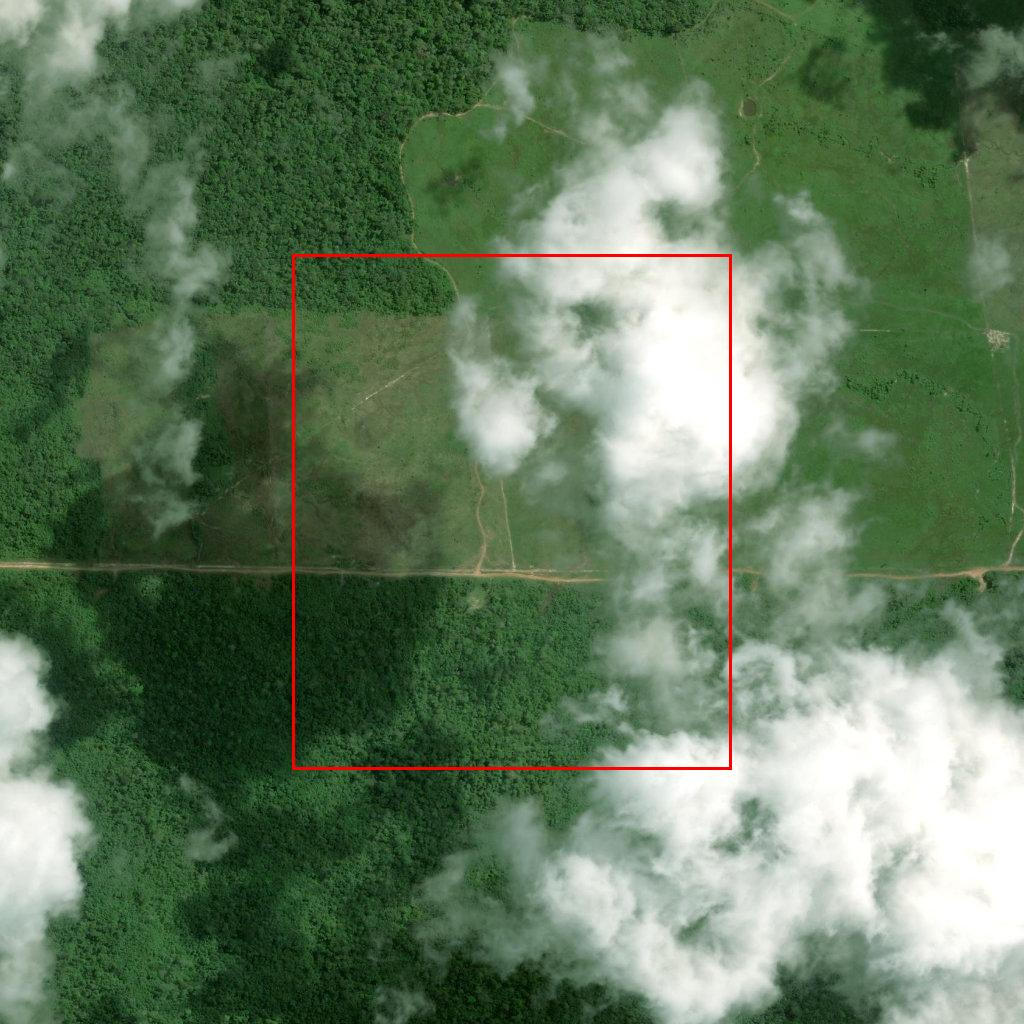

In [7]:
# OPTIONAL - Get folium.Map satellite image as JPEG

def get_esri_satellite_image(min_lat, max_lat, min_lon, max_lon, width=512, height=512, buffer_m=500, save_path=None):  # CHANGED: added buffer_m argument
    url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export"

    # CHANGED: convert buffer in metres to degrees based on latitude
    centre_lat = (min_lat + max_lat) / 2
    metres_per_deg_lat = 111320
    metres_per_deg_lon = 111320 * math.cos(math.radians(centre_lat))
    delta_lat = buffer_m / metres_per_deg_lat
    delta_lon = buffer_m / metres_per_deg_lon

    # CHANGED: expand bounding box
    ext_min_lat = min_lat - delta_lat
    ext_max_lat = max_lat + delta_lat
    ext_min_lon = min_lon - delta_lon
    ext_max_lon = max_lon + delta_lon

    # CHANGED: use buffered bbox
    bbox = f"{ext_min_lon},{ext_min_lat},{ext_max_lon},{ext_max_lat}"
    params = {
        "bbox": bbox,
        "bboxSR": 4326,
        "imageSR": 4326,
        "size": f"{width},{height}",
        "format": "jpg",
        "f": "image"
    }

    r = requests.get(url, params=params)
    r.raise_for_status()

    image = Image.open(BytesIO(r.content))

    # CHANGED: draw red rectangle over original tile bbox
    draw = ImageDraw.Draw(image)

    def lonlat_to_pixel(lon, lat):
        x_frac = (lon - ext_min_lon) / (ext_max_lon - ext_min_lon)
        y_frac = 1 - (lat - ext_min_lat) / (ext_max_lat - ext_min_lat)
        return int(x_frac * width), int(y_frac * height)

    x0, y0 = lonlat_to_pixel(min_lon, max_lat)  # top-left
    x1, y1 = lonlat_to_pixel(max_lon, min_lat)  # bottom-right
    draw.rectangle([(x0, y0), (x1, y1)], outline="red", width=3)

    if save_path:
        image.save(save_path)

    return image

def fetch_esri_satellite(min_lat, max_lat, min_lon, max_lon,
                         width=512, height=512,
                         buffer_m=0,
                         annotate=False,
                         save_path=None):
    """
    Download World Imagery for the given lat/lon bbox.

    • buffer_m   – metres to expand the bbox (0 → none)  
    • annotate   – draw a red rectangle around the *original* bbox  
    • save_path  – optional path to save the JPEG  

    Returns a PIL.Image.
    """
    # -----------------------------------------------------------
    # optional buffer → degrees
    # -----------------------------------------------------------
    centre_lat = (min_lat + max_lat) / 2
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * math.cos(math.radians(centre_lat))

    d_lat = buffer_m / m_per_deg_lat
    d_lon = buffer_m / m_per_deg_lon

    ext_min_lat = min_lat - d_lat
    ext_max_lat = max_lat + d_lat
    ext_min_lon = min_lon - d_lon
    ext_max_lon = max_lon + d_lon

    # -----------------------------------------------------------
    # Esri REST export
    # -----------------------------------------------------------
    url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export"
    params = {
        "bbox": f"{ext_min_lon},{ext_min_lat},{ext_max_lon},{ext_max_lat}",
        "bboxSR": 4326,
        "imageSR": 4326,
        "size": f"{width},{height}",
        "format": "jpg",
        "f": "image"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    img = Image.open(BytesIO(r.content))

    # -----------------------------------------------------------
    # optional red outline of the *unbuffered* area
    # -----------------------------------------------------------
    if annotate and buffer_m > 0:
        draw = ImageDraw.Draw(img)

        def lonlat_to_px(lon, lat):
            x = (lon - ext_min_lon) / (ext_max_lon - ext_min_lon) * width
            y = (1 - (lat - ext_min_lat) / (ext_max_lat - ext_min_lat)) * height
            return int(x), int(y)

        tl = lonlat_to_px(min_lon, max_lat)   # top-left
        br = lonlat_to_px(max_lon, min_lat)   # bottom-right
        draw.rectangle([tl, br], outline="red", width=3)

    if save_path:
        img.save(save_path, format="JPEG")

    return img

def satellite_tile_cropped(min_lat, max_lat, min_lon, max_lon,
                           width=1024, buffer_m=250,
                           outline=True, save_path=None):
    """
    Returns (cropped_img, full_img)  – both are PIL.Image.

    • width        – pixel width of the *downloaded* JPEG (height auto-scaled)
    • buffer_m     – metres to add to all four sides before requesting
    • outline      – draw a red rectangle on the cropped image
    """
    # 1 — expand the bbox so the export call is happy
    centre_lat = (min_lat + max_lat) / 2
    m_per_deg_lat = 111_320
    m_per_deg_lon = 111_320 * math.cos(math.radians(centre_lat))

    d_lat = buffer_m / m_per_deg_lat
    d_lon = buffer_m / m_per_deg_lon

    ext_min_lat = min_lat - d_lat
    ext_max_lat = max_lat + d_lat
    ext_min_lon = min_lon - d_lon
    ext_max_lon = max_lon + d_lon

    # keep the same pixel size in X and Y
    lat_span = ext_max_lat - ext_min_lat
    lon_span = ext_max_lon - ext_min_lon
    height = round(width * lat_span / lon_span)

    # 2 — download
    url = ("https://services.arcgisonline.com/ArcGIS/rest/services/"
           "World_Imagery/MapServer/export")
    params = {
        "bbox": f"{ext_min_lon},{ext_min_lat},{ext_max_lon},{ext_max_lat}",
        "bboxSR": 4326,
        "imageSR": 4326,
        "size": f"{width},{height}",
        "format": "jpg",
        "f": "image",
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    full_img = Image.open(BytesIO(r.content))

    # 3 — convert lat/lon to pixel, crop
    def lonlat_to_px(lon, lat):
        x = (lon - ext_min_lon) / (ext_max_lon - ext_min_lon) * width
        y = (1 - (lat - ext_min_lat) / (ext_max_lat - ext_min_lat)) * height
        return int(round(x)), int(round(y))

    x0, y0 = lonlat_to_px(min_lon, max_lat)   # upper-left in PIL coords
    x1, y1 = lonlat_to_px(max_lon, min_lat)   # lower-right

    cropped = full_img.crop((x0, y0, x1, y1))

    # 4 — optional outline
    if outline:
        draw = ImageDraw.Draw(cropped)
        draw.rectangle([0, 0, cropped.width - 1, cropped.height - 1],
                       outline="red", width=2)

    if save_path:
        cropped.save(save_path, format="JPEG")

    return cropped, full_img

img = get_esri_satellite_image(min_lat, max_lat, min_lon, max_lon, width=1024, height=1024)
buffer = BytesIO()
img.save(buffer, format="JPEG")
display(IPyImage(data=buffer.getvalue(), width=400))  # Display at fixed width

In [8]:
# OPTIONAL - Download tile
download_dir = os.path.join(os.getcwd(), "data", "tiles", "laz")
os.makedirs(download_dir, exist_ok=True)

base_url = "https://daac.ornl.gov/daacdata/cms/LiDAR_Forest_Inventory_Brazil/data/"
filename = tile_metadata_df.iloc[tile_index]["filename"]
url = f"{base_url}/{filename}"

destination_path = os.path.join(download_dir, filename)

with requests.Session() as session:
    # Enable netrc authentication for urs.earthdata.nasa.gov
    session.auth = None  # triggers use of ~/.netrc
    session.headers.update({"User-Agent": "earthdata-download-script"})

    t0 = time.time()
    r = session.get(url, allow_redirects=True)
    t1 = time.time()
    elapsed_time = t1 - t0

    if r.status_code == 200:
        with open(destination_path, "wb") as f:
            f.write(r.content)
        file_size_mb = os.path.getsize(destination_path) / (1024 * 1024)
        print(f"Downloaded {filename} to {destination_path}")
        print(f"Time taken: {elapsed_time:.2f} seconds")
        print(f"File size: {file_size_mb:.2f} MB")
    else:
        print(f"Failed with status {r.status_code}")
        print(r.url)
        print(r.text[:500])

Downloaded AND_A01_2013_laz_11.laz to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/tiles/laz/AND_A01_2013_laz_11.laz
Time taken: 17.17 seconds
File size: 63.86 MB


In [9]:
tile_name = tile_metadata_df.iloc[tile_index]["filename"]
print(f"Tile name: {tile_name})")
tile_metadata_df[tile_metadata_df["filename"] == tile_name]

Tile name: AND_A01_2013_laz_11.laz)


,filename,max_lat,min_lat,max_lon,min_lon,file_type,file_size_mb,file_format,version,created,utmzone,srs
28,AND_A01_2013_laz_11.laz,-2.540966,-2.55002,-46.828031,-46.834794,pointcloud,66.959251,LAS/LAZ,1.0,178/2014,23S,+proj=utm +zone=23 +south +ellps=GRS80 +towgs8...


In [10]:
def tile_bounds(laz_path, res=2.0):
    """Round LAS extents to the nearest grid step so DSM/DTM align."""
    with laspy.open(laz_path) as f:
        h = f.header
    min_x = floor(h.mins[0] / res) * res
    max_x = ceil (h.maxs[0] / res) * res
    min_y = floor(h.mins[1] / res) * res
    max_y = ceil (h.maxs[1] / res) * res
    return min_x, max_x, min_y, max_y

def load_filter_spec(spec_path: str) -> list:
    """Read a JSON file whose root object is {'pipeline': [ …filters… ]}."""
    with open(spec_path, "r") as f:
        return json.load(f)["pipeline"]


def build_pipeline(laz_path, filters, out_tif,
                   res=2.0, out_type="idw",
                   bounds=None, spatialreference=None,
                   nodata=-9999):                    # NEW default
    writer = {
        "type": "writers.gdal",
        "filename": out_tif,
        "gdaldriver": "GTiff",
        "resolution": res,
        "output_type": out_type,
        "nodata": nodata                       # NEW
    }
    if bounds:
        writer["bounds"] = bounds
    if spatialreference:                     # NEW
        writer["spatialreference"] = spatialreference

    return {"pipeline": [laz_path] + filters + [writer]}


def run_pipeline(pipeline_def: dict) -> None:
    """Execute a PDAL pipeline."""
    p = pdal.Pipeline(json.dumps(pipeline_def))
    p.execute()


def create_chm(dsm_path, dtm_path, chm_path,
               nodata=-9999,
               max_height=60):
    """
    Create canopy-height model (DSM – DTM).

    * masks negative results and those above `max_height`
    * writes nodata as `nodata`
    """
    with rasterio.open(dtm_path) as dtm, rasterio.open(dsm_path) as dsm:
        if dtm.transform != dsm.transform or dtm.crs != dsm.crs:
            raise ValueError("DSM and DTM grids differ – fix alignment first.")

        dtm_data = dtm.read(1, masked=True)
        dsm_data = dsm.read(1, masked=True)

        profile = dtm.profile.copy()          # copy BEFORE leaving the block

    chm = dsm_data - dtm_data
    chm = np.ma.masked_where(chm < 0, chm)
    chm = np.ma.masked_where(chm > max_height, chm)

    profile.update(dtype=rasterio.float32, nodata=nodata)

    with rasterio.open(chm_path, "w", **profile) as dst:
        dst.write(chm.filled(nodata).astype(rasterio.float32), 1)


from matplotlib.colors import LightSource

def create_hillshade(dtm_path, hill_path,
                     azim: float = 315,
                     alt: float = 45,
                     exaggeration: float = 1.0):
    """Analytic hill-shade derived from the DTM."""
    with rasterio.open(dtm_path) as src:
        z = src.read(1, masked=True)
        dx, dy = src.res

        # ---- fixed line -------------------------------------------------
        ls = LightSource(azdeg=azim, altdeg=alt)
        # ----------------------------------------------------------------

        hs = ls.hillshade(z,
                          vert_exag=exaggeration,
                          dx=dx, dy=dy)

        profile = src.profile
        profile.update(dtype=rasterio.uint8, nodata=None)

        with rasterio.open(hill_path, "w", **profile) as dst:
            dst.write((hs * 255).astype(rasterio.uint8), 1)



def raster_bounds_latlon(raster_path: str) -> dict:
    """Return bbox + centre in WGS84, regardless of raster CRS."""
    with rasterio.open(raster_path) as src:
        b = src.bounds
        if src.crs.is_geographic:
            min_lon, min_lat, max_lon, max_lat = b
        else:
            min_lon, min_lat, max_lon, max_lat = transform_bounds(src.crs,
                                                                  "EPSG:4326",
                                                                  *b,
                                                                  densify_pts=21)
        return {
            "min_lat": min_lat, "max_lat": max_lat,
            "min_lon": min_lon, "max_lon": max_lon,
            "centre_lat": (min_lat + max_lat) / 2,
            "centre_lon": (min_lon + max_lon) / 2,
        }
    
def laz_spatialref_wkt(laz_path):
    """Return the CRS in WKT, or None if the LAS header has no CRS."""
    with laspy.open(laz_path) as f:
        crs = f.header.parse_crs()
    return crs.to_wkt() if crs else None

def crs_from_metadata(tile_metadata_df, tile_name):
    """Return the PROJ string from the 'srs' column for a given tile."""
    row = tile_metadata_df.loc[tile_metadata_df["filename"] == tile_name]
    if row.empty:
        raise ValueError(f"No metadata row found for {tile_name}")
    return row.iloc[0]["srs"]

In [12]:
# ------------------------------------------------------------------
# paths
# ------------------------------------------------------------------
cwd = os.getcwd()

download_dir        = os.path.join(cwd, "data", "tiles")                       # where the .laz lives
path_to_pipeline_defs = os.path.join(cwd, "notebooks", "laz_to_dtm", "pipeline_defs")
path_to_models        = os.path.join(cwd, "notebooks", "laz_to_dtm", "models")

for p in (path_to_pipeline_defs, path_to_models):
    os.makedirs(p, exist_ok=True)

In [13]:
download_dir = '/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/tiles/laz'

In [ ]:
laz_path = os.path.join(download_dir, tile_name)

sr_wkt = laz_spatialref_wkt(laz_path)          # might be None
if sr_wkt is None:
    sr_wkt = crs_from_metadata(tile_metadata_df, tile_name)


# out files
stem      = os.path.splitext(tile_name)[0]          # "ANA_A01_2017"
dtm_path  = os.path.join(path_to_models, f"{stem}_dtm.tif")
dsm_path  = os.path.join(path_to_models, f"{stem}_dsm.tif")
chm_path  = os.path.join(path_to_models, f"{stem}_chm.tif")
hill_path = os.path.join(path_to_models, f"{stem}_hillshade.tif")

dtm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs, "dtm_filters.json"))
dsm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs, "dsm_filters.json"))

# fixed bounds already computed above
min_x, max_x, min_y, max_y = tile_bounds(laz_path, res=2.0)
bbox = f"([{min_x},{max_x}], [{min_y},{max_y}])"

# build + run DTM
dtm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs, "dtm_filters.json"))
dtm_pipe = build_pipeline(laz_path, dtm_filters, dtm_path, bounds=bbox, spatialreference=sr_wkt)
run_pipeline(dtm_pipe)

# build + run DSM
dsm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs, "dsm_filters.json"))
dsm_pipe = build_pipeline(laz_path, dsm_filters, dsm_path, bounds=bbox, spatialreference=sr_wkt)
run_pipeline(dsm_pipe)

# derived products
create_chm(dsm_path, dtm_path, chm_path)
create_hillshade(dtm_path, hill_path)


# # ----------------------------------------------------------------
# # fixed grid bounds for both DSM and DTM
# # ----------------------------------------------------------------
# min_x, max_x, min_y, max_y = tile_bounds(laz_path, res=2.0)
# bbox = f"([{min_x},{max_x}], [{min_y},{max_y}])"

# # ---------------------------------------------------------------
# # build + run DTM pipeline
# # ---------------------------------------------------------------
# dtm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs,
#                                            "dtm_filters.json"))
# dtm_pipe = build_pipeline(laz_path, dtm_filters, dtm_path)
# run_pipeline(dtm_pipe)

# ---------------------------------------------------------------
# build + run DSM pipeline
# ---------------------------------------------------------------
# dsm_filters = load_filter_spec(os.path.join(path_to_pipeline_defs,
#                                            "dsm_filters.json"))
# dsm_pipe = build_pipeline(laz_path, dsm_filters, dsm_path)
# run_pipeline(dsm_pipe)

# ---------------------------------------------------------------
# derived products
# ---------------------------------------------------------------
create_chm(dsm_path, dtm_path, chm_path)
create_hillshade(dtm_path, hill_path)

print("Finished processing:")
for p in (dtm_path, dsm_path, chm_path, hill_path):
    print("  •", p)

Finished processing:
  • /Users/jamesbyers/code/github/Kaggle/openai_to_z/notebooks/laz_to_dtm/models/AND_A01_2013_laz_11_dtm.tif
  • /Users/jamesbyers/code/github/Kaggle/openai_to_z/notebooks/laz_to_dtm/models/AND_A01_2013_laz_11_dsm.tif
  • /Users/jamesbyers/code/github/Kaggle/openai_to_z/notebooks/laz_to_dtm/models/AND_A01_2013_laz_11_chm.tif
  • /Users/jamesbyers/code/github/Kaggle/openai_to_z/notebooks/laz_to_dtm/models/AND_A01_2013_laz_11_hillshade.tif


In [15]:
b = raster_bounds_latlon(dtm_path)
print("Centre (lat, lon):", (b["centre_lat"], b["centre_lon"]))
print("Bounds:")
for k in ("min_lat", "max_lat", "min_lon", "max_lon"):
    print(f"  {k}: {b[k]}")


Centre (lat, lon): (-2.545484971936464, -46.83140899562257)
Bounds:
  min_lat: -2.5500381815711886
  max_lat: -2.540931762301739
  min_lon: -46.83480500174365
  max_lon: -46.82801298950149


In [17]:
def plot_products(
        sat_img, dsm_path, dtm_path, chm_path, hill_path,
        overlay=None, overlay_alpha=0.4,                 # NEW
        title="LiDAR products"):

    """
    overlay: None | "hillshade" | "dtm"
    """
    import matplotlib.pyplot as plt
    from rasterio.plot import show

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16)

    # --------------- satellite pane ------------------------------
    axs[0, 0].imshow(sat_img)
    axs[0, 0].set_title("Satellite (Esri World Imagery)")
    axs[0, 0].axis("off")

    rasters = [
        (dsm_path,  "DSM",        axs[0, 1], "terrain"),
        (dtm_path,  "DTM",        axs[0, 2], "terrain"),
        (chm_path,  "CHM",        axs[1, 0], "viridis"),
        (hill_path, "Hill-shade", axs[1, 1], "gray"),
    ]

    for path, ttl, ax, cmap in rasters:
        with rasterio.open(path) as src:
            img = src.read(1, masked=True)
            if ttl == "Hill-shade":
                img = img.astype(float) / 255
            im = ax.imshow(img, cmap=cmap)
            ax.set_title(ttl)
            ax.axis("off")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # --------------- overlay pane -------------------------------
    ax_over = axs[1, 2]          # lower-right
    ax_over.axis("off")

    if overlay in ("hillshade", "dtm"):
        rel_path = hill_path if overlay == "hillshade" else dtm_path

        # bounds for reprojection
        left, bottom, right, top = (
            raster_bounds_latlon(dtm_path)["min_lon"],
            raster_bounds_latlon(dtm_path)["min_lat"],
            raster_bounds_latlon(dtm_path)["max_lon"],
            raster_bounds_latlon(dtm_path)["max_lat"],
        )
        relief = raster_to_image_grid(
            rel_path,
            sat_img.width, sat_img.height,
            (left, bottom, right, top)
        )
        blended = overlay_relief_on_sat(sat_img, relief,
                                        alpha=overlay_alpha,
                                        cmap="gray" if overlay == "hillshade" else "terrain")
        ax_over.imshow(blended)
        ax_over.set_title(f"Satellite + {overlay}")
    else:
        ax_over.text(0.5, 0.5, "No overlay", ha="center", va="center")

    plt.tight_layout()
    plt.show()

def overlay_relief_on_sat(sat_img, relief, *,
                          mode="alpha", alpha=0.4,
                          cmap="gray"):
    """
    sat_img   – PIL.Image RGB
    relief    – float array 0-1 matching sat dimensions
    mode      – "alpha" (simple transparency) or "multiply"
    alpha     – only for alpha mode
    cmap      – matplotlib colormap name for non-greyscale overlays
    """
    sat = np.asarray(sat_img).astype(np.float32) / 255.0

    if cmap == "gray":
        rgb_relief = np.repeat(relief[:, :, None], 3, axis=2)
    else:
        import matplotlib.cm as cm
        rgb_relief = cm.get_cmap(cmap)(relief)[:, :, :3]

    if mode == "alpha":
        blended = (1 - alpha) * sat + alpha * rgb_relief
    elif mode == "multiply":
        # brighten / darken depending on relief
        blended = sat * (0.6 + 0.8 * rgb_relief)
    else:
        raise ValueError("mode must be 'alpha' or 'multiply'")

    blended = np.clip(blended * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(blended)

def raster_to_image_grid(raster_path, dst_w, dst_h, dst_bounds, dst_crs="EPSG:4326"):
    """
    Reprojects `raster_path` into the satellite grid defined by
    (dst_bounds, dst_w, dst_h).  Returns float32 array in 0-1 range.
    """
    left, bottom, right, top = dst_bounds
    dst_transform = from_bounds(left, bottom, right, top, dst_w, dst_h)

    dst = np.empty((dst_h, dst_w), dtype=np.float32)

    with rasterio.open(raster_path) as src:
        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )

    dst = np.ma.masked_invalid(dst)
    rng = dst.max() - dst.min()
    if rng > 0:
        dst = (dst - dst.min()) / rng
    else:
        dst = dst * 0.0
    return dst.filled(0)

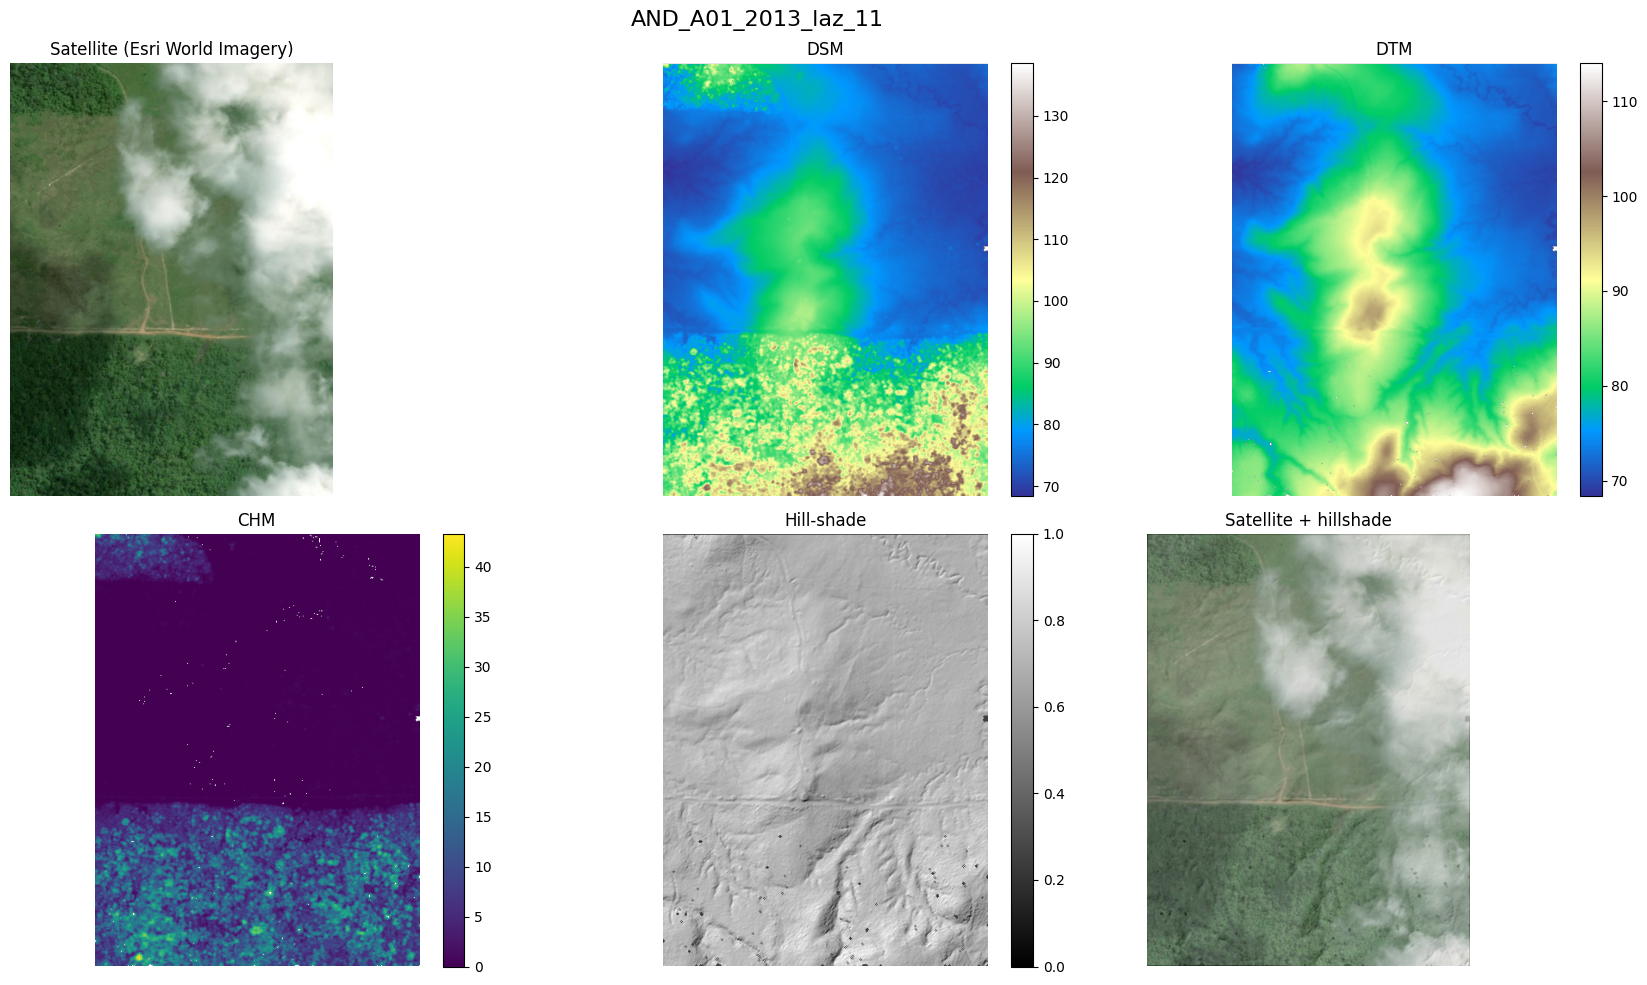

In [18]:

# ------------------------------------------------------------------
# get a JPEG satellite tile using your existing routine
# ------------------------------------------------------------------
bounds = raster_bounds_latlon(dtm_path)
# sat_img = get_esri_satellite_image(bounds["min_lat"], bounds["max_lat"],
#                                    bounds["min_lon"], bounds["max_lon"],
#                                    width=1024, height=1024,
#                                    buffer_m=500)
# sat_img = fetch_esri_satellite(bounds["min_lat"], bounds["max_lat"],
#                                bounds["min_lon"], bounds["max_lon"],
#                                width=1024, height=1024,
#                                buffer_m=0)      # ← no buffer
crop_img, _ = satellite_tile_cropped(
    bounds["min_lat"], bounds["max_lat"],
    bounds["min_lon"], bounds["max_lon"],
    width=1024,         # download resolution
    buffer_m=250,       # extra context just for the server
    outline=False       # set True if you want a red border
)
# ------------------------------------------------------------------
# plot everything
# ------------------------------------------------------------------
plot_products(
    crop_img, dsm_path, dtm_path, chm_path, hill_path,
    overlay="hillshade", overlay_alpha=0.35,
    title=os.path.splitext(tile_name)[0]
)

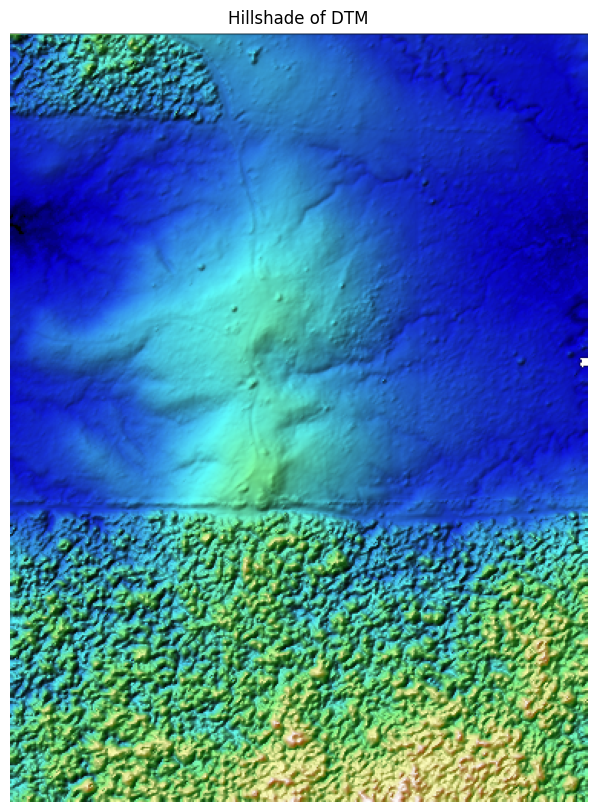

In [19]:
with rasterio.open(dsm_path) as dsm_src, rasterio.open(dtm_path) as dtm_src:
    dsm = dsm_src.read(1)
    dtm = dtm_src.read(1)

    # Mask nodata
    dsm = np.ma.masked_equal(dsm, dsm_src.nodata)
    dtm = np.ma.masked_equal(dtm, dtm_src.nodata)
    
    # Combined mask: exclude any location where either raster has nodata
    mask = np.ma.mask_or(np.ma.getmask(dsm), np.ma.getmask(dtm))
    
    chm = np.ma.array(dsm - dtm, mask=mask)
    
    # Optional: clip unrealistic values
    chm = np.clip(chm, 0, 60)  # e.g. 0–60 m tree height

ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.shade(dsm, cmap=plt.cm.gist_earth, vert_exag=1.5, blend_mode='overlay')

plt.figure(figsize=(10, 10))
plt.imshow(hillshade)
plt.title("Hillshade of DTM")
plt.axis("off")
plt.show()
